# <center> ___Group Project Notebook___</center>

# Imports and environment variable.

In [189]:
import pandas as pd
import numpy as np

from scipy.optimize import newton, fsolve, bisect

import secrets

import matplotlib.pyplot as plt

import os

from IPython import get_ipython
from IPython.display import Image, display


from comp_econ import comp_econ as ce

image_dir = os.getenv("ECON_560_IMAGE_DIR")

# Problem 1: Expected value and variance of the international price of bananas.

## To find the equilibrium price p_star, we need a function P in terms of thetas and alphas.<br> p_star = p(theta_s, theta_us, theta_rw, alpha_s, alpha_us, alpha_rw).<br>Use the given equations and fsolve for P.

In [190]:
def p(
    _log_price: float, 
    _theta_s: float,
    _theta_us: float,
    _theta_rw: float,
    _alpha_s: float,
    _alpha_us: float,
    _alpha_rw: float
    ) -> float:
    """
    S = D_us + D_rw\n
    D_us + D_rw - S = 0\n
    (theta_us * (P ** -alpha_us)) + (theta_rw * (P ** -alpha_rw)) - (theta_s * (P ** alpha_s))\n
    """
        
    # Account for the possibility that fsolve will consider negative prices as a solution.
    _price = np.exp(_log_price)

    return (_theta_us * (_price ** -_alpha_us)) + (_theta_rw * (_price ** -_alpha_rw)) - (_theta_s * (_price ** _alpha_s))
    


## Define thetas and alphas.

In [191]:
# Generator instance, per the numpy docs.
# https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
# Set a seed for reproducable results.
# rng = np.random.default_rng(seed=123)
rng = np.random.default_rng()
# Number of samples to draw.
N = 10_000

# theta_s ~ lnN(0, 0.7)
theta_s = rng.lognormal(mean=0, sigma=(0.7**(1/2)), size=N)

# theta_us ~ lnN(0, 0.01)
theta_us = rng.lognormal(mean=0, sigma=(0.01**(1/2)), size=N)

# theta_rw ~ lnN(0, 0.03)
theta_rw = rng.lognormal(mean=0, sigma=(0.03**(1/2)), size=N)

alpha_s = 0.7
alpha_us = 0.3
alpha_rw = 0.2


## Use fsolve to find the equilibrium price p_star.

In [192]:
# Create Nx1 numpy arrays having nan values.
log_p_star = np.full(N, np.nan)
p_star = np.full(N, np.nan)

# Loop over every simulated p_i = p(theta_s[i], ..., alpha_rw).
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
for i in range(N):
    log_p_i = fsolve(
        p,
        x0=0,
        args=(theta_s[i], theta_us[i], theta_rw[i], alpha_s, alpha_us, alpha_rw)
    )[0]
    # Undo the log transform of price.
    p_i_star = np.exp(log_p_i)
    
    # Update the arrays.
    log_p_star[i] = log_p_i
    p_star[i] = p_i_star


## Confirm that each p_i_star solves its corresponding ith equation `p(log_p_star[i], theta_s[i], theta_us[i], theta_rw[i], alpha_s, alpha_us, alpha_rw)`.


In [193]:
for i in range(N):
  assert np.isclose(
    p(log_p_star[i],
      theta_s[i],
      theta_us[i],
      theta_rw[i],
      alpha_s,
      alpha_us,
      alpha_rw
    ),
    0
  ), f"p_star does not solve the equation in function p(_price, ..., _alpha_rw) at index {i}"


## Expectation and variance of p_star.

In [194]:
expected_p_star = p_star.mean()
print(f"Expected equilibrium price, E[p_star] = {expected_p_star}")

var_p_star = p_star.var(ddof=1)
print(f"Variance of equilibrium price, Var[p_star] = {var_p_star}")

Expected equilibrium price, E[p_star] = 3.0817681318747385
Variance of equilibrium price, Var[p_star] = 11.616325345646745


## Plot of p_star and fitted Lognormal PDF.

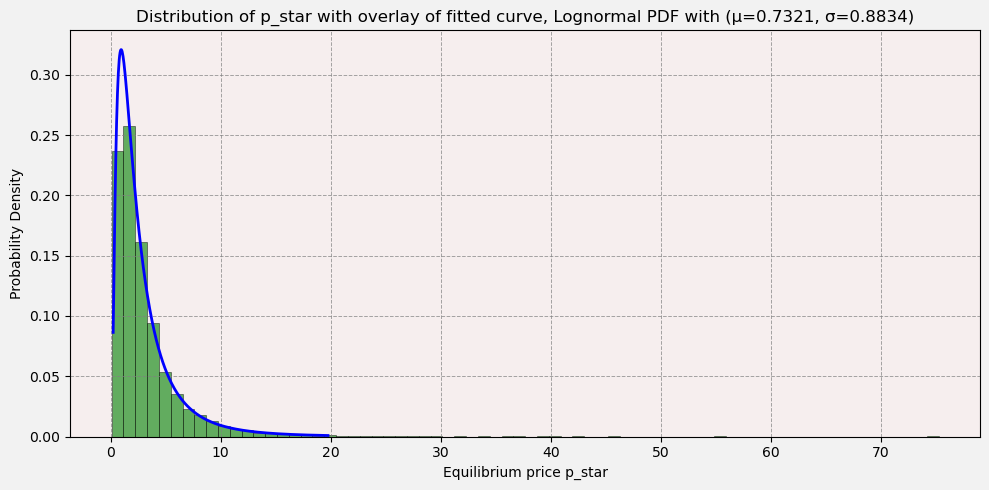

In [195]:
# Fitted lognormal parameters.
# Pull the fitted values from log_p_star, not p_star, because want to overlay with a fitted Lognormal PDF.
mu_fit = log_p_star.mean()
sigma_fit = log_p_star.std(ddof=1)

# x-grid for the fitted Lognormal PDF.
x = np.linspace(np.percentile(p_star, 0.5), np.percentile(p_star, 99.5), 500)

# Formula of a Lognormal PDF.
pdf_fit = (1 / (x * sigma_fit * np.sqrt(2*np.pi))) * \
          np.exp(-(np.log(x) - mu_fit)**2 / (2 * sigma_fit**2))

# Assign fig and ax with background.
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("#f2f2f2")
ax.set_facecolor("#F7EEEEFA")

# Create the grid.
ax.grid(
    True,
    linestyle="--",
    linewidth=0.7,
    alpha=0.7,
    color="gray"
)

# Histogram plot with edges.
ax.hist(
    p_star,
    bins=70,
    density=True,
    alpha=0.6,
    color="green",
    edgecolor="black",
    linewidth=0.5
)

# Plot the Lognormal PDF.
ax.plot(x, pdf_fit, linewidth=2, color="blue")

ax.set_xlabel("Equilibrium price p_star")
ax.set_ylabel("Probability Density")
ax.set_title(f"Distribution of p_star with overlay of fitted curve, Lognormal PDF with (μ={np.round(mu_fit, 4)}, σ={np.round(sigma_fit, 4)})")

plt.tight_layout()
plt.savefig(rf'{image_dir}\\lognormal_plot.png', dpi=300)
plt.show()


## Let's take a look at several equations and their solutions, p_i_star.

In [196]:

theta_us_list = []
theta_rw_list = []
theta_s_list = []
p_equilibrium_list = []
result_list = []

start = 0
length = 10
end = start + length
for i in range(start, end):
    p_equilibrium_i = p_star[i]

    equation_i = f"({theta_us[i]} * (p_equilibrium_i ** - {alpha_us})) + ({theta_rw[i]} * (p_equilibrium_i ** - {alpha_rw})) - ({theta_s[i]} * (p_equilibrium_i ** {alpha_s}))"

    result = (theta_us[i] * (p_equilibrium_i ** - alpha_us)) + (theta_rw[i] * (p_equilibrium_i ** - alpha_rw)) - (theta_s[i] * (p_equilibrium_i ** alpha_s))

    print(f'p_equilibrium_i = {p_equilibrium_i}')
    print(f'equation_i = {equation_i}')
    print(f'result = {result}')
    print()

    theta_us_list.append(theta_us[i])
    theta_rw_list.append(theta_rw[i])
    theta_s_list.append(theta_s[i])
    p_equilibrium_list.append(p_equilibrium_i)
    result_list.append(result)

df = pd.DataFrame(data={
    'p_i_star': p_equilibrium_list,
    'theta_us': theta_us_list,
    'alpha_us': [alpha_us]*length,
    'theta_rw': theta_rw_list,
    'alpha_rw': [alpha_rw]*length,
    'theta_s': theta_s_list,
    'alpha_s': [alpha_s]*length,
    'result': result_list
    },
    index=[f"equation_{i}" for i in range(start, end)]
).round(5)

df


p_equilibrium_i = 1.2832857257496435
equation_i = (1.123506542107071 * (p_equilibrium_i ** - 0.3)) + (0.8798029763592977 * (p_equilibrium_i ** - 0.2)) - (1.5783935071591118 * (p_equilibrium_i ** 0.7))
result = 2.220446049250313e-16

p_equilibrium_i = 0.44997515099913976
equation_i = (0.9028457032229584 * (p_equilibrium_i ** - 0.3)) + (0.832991784838245 * (p_equilibrium_i ** - 0.2)) - (3.715548613388133 * (p_equilibrium_i ** 0.7))
result = -2.220446049250313e-15

p_equilibrium_i = 1.3845272690501105
equation_i = (0.9452945160871503 * (p_equilibrium_i ** - 0.3)) + (1.1603972962100095 * (p_equilibrium_i ** - 0.2)) - (1.5485915711736602 * (p_equilibrium_i ** 0.7))
result = -2.220446049250313e-16

p_equilibrium_i = 0.5284435241596932
equation_i = (1.049946759677492 * (p_equilibrium_i ** - 0.3)) + (1.0222846268071488 * (p_equilibrium_i ** - 0.2)) - (3.801851828561714 * (p_equilibrium_i ** 0.7))
result = 0.0

p_equilibrium_i = 1.7560864478868985
equation_i = (1.061219345236487 * (p_equilibriu

,p_i_star,theta_us,alpha_us,theta_rw,alpha_rw,theta_s,alpha_s,result
equation_0,1.28329,1.12351,0.3,0.87980,0.2,1.57839,0.7,0.0
equation_1,0.44998,0.90285,0.3,0.83299,0.2,3.71555,0.7,-0.0
equation_2,1.38453,0.94529,0.3,1.16040,0.2,1.54859,0.7,-0.0
equation_3,0.52844,1.04995,0.3,1.02228,0.2,3.80185,0.7,0.0
equation_4,1.75609,1.06122,0.3,0.95665,0.2,1.18063,0.7,0.0
equation_5,8.59585,0.88798,0.3,1.11076,0.2,0.26354,0.7,0.0
equation_6,2.03120,0.91869,0.3,1.01879,0.2,0.99069,0.7,0.0
equation_7,2.87875,1.04078,0.3,0.79849,0.2,0.66985,0.7,0.0
equation_8,3.46567,1.14175,0.3,0.98693,0.2,0.65191,0.7,-0.0
equation_9,1.88083,1.04036,0.3,1.06178,0.2,1.15448,0.7,0.0


In [197]:
df['p_i_star'].mean()

np.float64(2.4254629999999997)

In [198]:
df['p_i_star'].var(ddof=1)

np.float64(5.5722926762455565)

## Supply and demand with equilibrium price.

Mean-like draw index: 5095, p_a* ≈ 3.0818
Extreme draw index: 3048, p_b* ≈ 75.2607


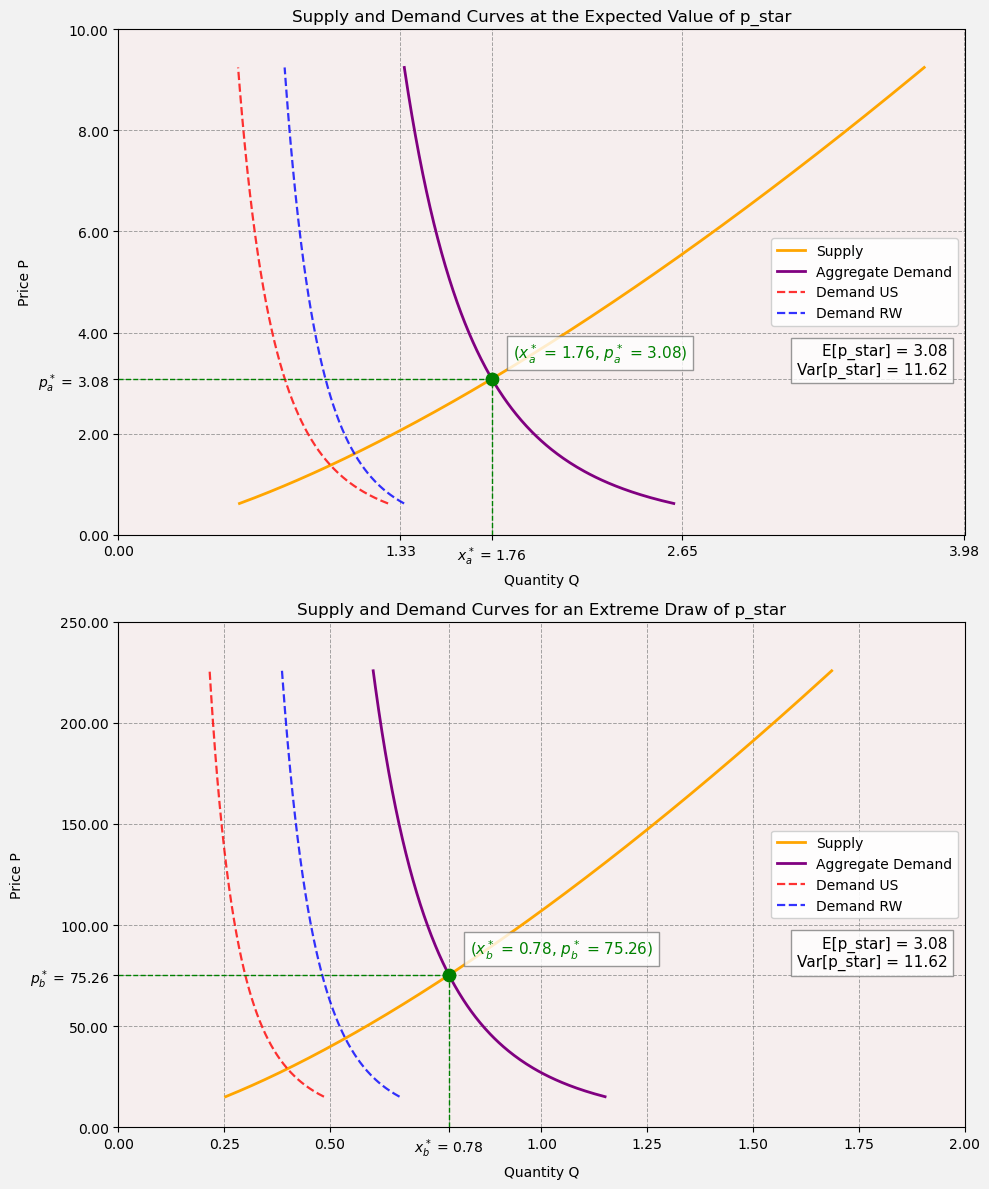

In [ ]:

#### AI assisted code for plotting.

# ========= Choose the two draws =========

# Draw A: closest to the expected value of p_star
target_p = expected_p_star
i_mean = np.argmin(np.abs(p_star - target_p))

theta_s_mean  = theta_s[i_mean]
theta_us_mean = theta_us[i_mean]
theta_rw_mean = theta_rw[i_mean]
p_star_mean   = p_star[i_mean]

print(f"Mean-like draw index: {i_mean}, p_a* ≈ {p_star_mean:.4f}")

# Equilibrium quantity for draw A
Q_eq_mean = theta_s_mean * (p_star_mean ** alpha_s)
P_eq_mean = p_star_mean

# Draw B: extreme (maximum) p_star
i_extreme = np.argmax(p_star)

theta_s_ext  = theta_s[i_extreme]
theta_us_ext = theta_us[i_extreme]
theta_rw_ext = theta_rw[i_extreme]
p_star_ext   = p_star[i_extreme]

print(f"Extreme draw index: {i_extreme}, p_b* ≈ {p_star_ext:.4f}")

# Equilibrium quantity for draw B
Q_eq_ext = theta_s_ext * (p_star_ext ** alpha_s)
P_eq_ext = p_star_ext


# ========= Create 2×1 figure =========

fig, (ax_mean, ax_ext) = plt.subplots(2, 1, figsize=(10, 12))
fig.patch.set_facecolor("#f2f2f2")


# --------------------------------------
# PANEL A — draw closest to E[p_star]
# --------------------------------------
ax = ax_mean
ax.set_facecolor("#F7EEEEFA")
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7, color="gray")

# Build curves for panel A
p_min_A = max(0.01, 0.2 * p_star_mean)
p_max_A = 3.0 * p_star_mean
p_grid_A = np.linspace(p_min_A, p_max_A, 300)

Qs_A     = theta_s_mean  * (p_grid_A ** alpha_s)
Qd_us_A  = theta_us_mean * (p_grid_A ** (-alpha_us))
Qd_rw_A  = theta_rw_mean * (p_grid_A ** (-alpha_rw))
Qd_tot_A = Qd_us_A + Qd_rw_A

# Curves
ax.plot(Qs_A,     p_grid_A, linewidth=2, color="orange", label="Supply")
ax.plot(Qd_tot_A, p_grid_A, linewidth=2, color="purple", label="Aggregate Demand")
ax.plot(Qd_us_A,  p_grid_A, linestyle="--", linewidth=1.6,
        color="red", alpha=0.8, label="Demand US")
ax.plot(Qd_rw_A,  p_grid_A, linestyle="--", linewidth=1.6,
        color="blue", alpha=0.8, label="Demand RW")

# Equilibrium point A
ax.scatter(Q_eq_mean, P_eq_mean, s=80, color="green", zorder=5)

# Annotation near equilibrium: (x_a*, p_a*)
ax.annotate(
    rf"($x_a^*$ = {Q_eq_mean:.2f}, $p_a^*$ = {P_eq_mean:.2f})",
    xy=(Q_eq_mean, P_eq_mean),
    xytext=(15, 15),
    textcoords="offset points",
    fontsize=11,
    color="green",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

# Dashed guides from origin to (x_a*, p_a*)
ax.plot([0, Q_eq_mean], [P_eq_mean, P_eq_mean],
        color="green", linestyle="--", linewidth=1)
ax.plot([Q_eq_mean, Q_eq_mean], [0, P_eq_mean],
        color="green", linestyle="--", linewidth=1)

# Legend in top-left
legend = ax.legend(loc="center right", framealpha=0.9)

# Stats box bottom-right
ax.text(
    0.98, 0.31,
    f"E[p_star] = {expected_p_star:.2f}\nVar[p_star] = {var_p_star:.2f}",
    transform=ax.transAxes,
    fontsize=11,
    ha="right",
    va="bottom",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

# y-axis ticks: mark p_a* cleanly
yticks = list(ax.get_yticks())
yticks = [t for t in yticks if abs(t - P_eq_mean) > 0.05 * max(P_eq_mean, 1e-8)]
yticks.append(P_eq_mean)
yticks = sorted(yticks)

ax.set_yticks(yticks)
ax.set_yticklabels([
    (rf"$p_a^*$ = {P_eq_mean:.2f}" if abs(t - P_eq_mean) < 1e-6 else f"{t:.2f}")
    for t in yticks
])

# --- FINAL CLEAN X-AXIS FOR EXPECTED VALUE PLOT ---

# 1. Determine axis limits
xmin, xmax = ax.get_xlim()

# 2. Make 4 evenly spaced clean ticks (0%, 33%, 66%, 100%)
base_xticks = np.linspace(0, xmax, 4)

# 3. Add the equilibrium quantity x_a*
all_xticks = list(base_xticks) + [Q_eq_mean]

# 4. Remove any values extremely close to each other (avoid near-duplicates)
clean_xticks = []
for t in sorted(all_xticks):
    if not clean_xticks or abs(t - clean_xticks[-1]) > 0.10 * xmax:
        clean_xticks.append(t)

# 5. Build labels — only x_a* gets a special label
xtick_labels = []
for t in clean_xticks:
    if abs(t - Q_eq_mean) < 1e-6:
        xtick_labels.append(rf"$x_a^*$ = {Q_eq_mean:.2f}")
    else:
        xtick_labels.append(f"{t:.2f}")

# 6. Set ticks
ax.set_xticks(clean_xticks)
ax.set_xticklabels(xtick_labels)



# Axis bounds and labels
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Quantity Q")
ax.set_ylabel("Price P")
ax.set_title("Supply and Demand Curves at the Expected Value of p_star")


# --------------------------------------
# PANEL B — extreme draw of p_star
# --------------------------------------
ax = ax_ext
ax.set_facecolor("#F7EEEEFA")
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7, color="gray")

# Build curves for panel B
p_min_B = max(0.01, 0.2 * p_star_ext)
p_max_B = 3.0 * p_star_ext
p_grid_B = np.linspace(p_min_B, p_max_B, 300)

Qs_B     = theta_s_ext  * (p_grid_B ** alpha_s)
Qd_us_B  = theta_us_ext * (p_grid_B ** (-alpha_us))
Qd_rw_B  = theta_rw_ext * (p_grid_B ** (-alpha_rw))
Qd_tot_B = Qd_us_B + Qd_rw_B

# Curves
ax.plot(Qs_B,     p_grid_B, linewidth=2, color="orange", label="Supply")
ax.plot(Qd_tot_B, p_grid_B, linewidth=2, color="purple", label="Aggregate Demand")
ax.plot(Qd_us_B,  p_grid_B, linestyle="--", linewidth=1.6,
        color="red", alpha=0.8, label="Demand US")
ax.plot(Qd_rw_B,  p_grid_B, linestyle="--", linewidth=1.6,
        color="blue", alpha=0.8, label="Demand RW")

# Equilibrium point B
ax.scatter(Q_eq_ext, P_eq_ext, s=80, color="green", zorder=5)

# Annotation near equilibrium: (x_b*, p_b*)
ax.annotate(
    rf"($x_b^*$ = {Q_eq_ext:.2f}, $p_b^*$ = {P_eq_ext:.2f})",
    xy=(Q_eq_ext, P_eq_ext),
    xytext=(15, 15),
    textcoords="offset points",
    fontsize=11,
    color="green",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

# Dashed guides from origin to (x_b*, p_b*)
ax.plot([0, Q_eq_ext], [P_eq_ext, P_eq_ext],
        color="green", linestyle="--", linewidth=1)
ax.plot([Q_eq_ext, Q_eq_ext], [0, P_eq_ext],
        color="green", linestyle="--", linewidth=1)

# Legend
legend = ax.legend(loc="center right", framealpha=0.9)

# Stats box
ax.text(
    0.98, 0.31,
    f"E[p_star] = {expected_p_star:.2f}\nVar[p_star] = {var_p_star:.2f}",
    transform=ax.transAxes,
    fontsize=11,
    ha="right",
    va="bottom",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

# y-axis ticks: mark p_b*
yticks = list(ax.get_yticks())
yticks = [t for t in yticks if abs(t - P_eq_ext) > 0.05 * max(P_eq_ext, 1e-8)]
yticks.append(P_eq_ext)
yticks = sorted(yticks)

ax.set_yticks(yticks)
ax.set_yticklabels([
    (rf"$p_b^*$ = {P_eq_ext:.2f}" if abs(t - P_eq_ext) < 1e-6 else f"{t:.2f}")
    for t in yticks
])

# x-axis ticks: mark x_b* (collision-safe)
xticks = list(ax.get_xticks())
xticks = [t for t in xticks if abs(t - Q_eq_ext) > 0.05 * max(Q_eq_ext, 1e-8)]
xticks.append(Q_eq_ext)
xticks = sorted(xticks)

ax.set_xticks(xticks)
ax.set_xticklabels([
    (rf"$x_b^*$ = {Q_eq_ext:.2f}" if abs(t - Q_eq_ext) < 1e-8 else f"{t:.2f}")
    for t in xticks
])

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Quantity Q")
ax.set_ylabel("Price P")
ax.set_title("Supply and Demand Curves for an Extreme Draw of p_star")


plt.tight_layout()

if image_dir is not None:
    plt.savefig(
        os.path.join(
            image_dir,
            "supply_and_demand_two_panel_expected_vs_extreme.png"
        ),
        dpi=300
    )

plt.show()
